## Chapter 19 - Metric Predicted Variable with One Nominal Predictor

- [19.3 - Hierarchical Bayesian Approach](#19.3---Hierarchical-Bayesian-Approach)
- [19.4 - Adding a Metric Predictor](#19.4---Adding-a-Metric-Predictor)
- [19.5 - Heterogeneous Variances and Robustness against Outliers](#19.5---Heterogeneous-Variances-and-Robustness-against-Outliers)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

from scipy.stats import norm
from IPython.display import Image
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [3]:
def plot_mustache(var, sd, j, axis, width=.75):
    for i in np.arange(start=0, stop=len(var), step=int(len(var)*.1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        
        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange*(width/xrange.max())
        
        # Using the negative value to flip the mustache in the right direction.
        axis.plot(-xrange_scaled+j, yrange, color=color, alpha=.6)

In [4]:
# Plot credible posterior distribution lines for model in section 19.4
def plot_cred_lines(b0, bj, bcov, x, ax):
   
    B = pd.DataFrame(np.c_[b0, bj, bcov], columns=['beta0', 'betaj', 'betacov'])
    
    # Credible posterior prediction lines
    hpd_interval = pm.hpd(B.as_matrix(), alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & 
              B.betaj.between(*hpd_interval[1,:]) &
              B.betacov.between(*hpd_interval[2,:])] 
    xrange = np.linspace(x.min()*.95, x.max()*1.05)
   
    for i in np.random.randint(0, len(B_hpd), 10):
        ax.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]+B_hpd.iloc[i,2]*xrange, c=color, alpha=.6, zorder=0)    

### 19.3 - Hierarchical Bayesian Approach

In [5]:
df = pd.read_csv('data/FruitflyDataReduced.csv', dtype={'CompanionNumber':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
Longevity          125 non-null int64
CompanionNumber    125 non-null category
Thorax             125 non-null float64
dtypes: category(1), float64(1), int64(1)
memory usage: 2.3 KB


In [6]:
df.groupby('CompanionNumber').head(2)

,Longevity,CompanionNumber,Thorax
0,35,Pregnant8,0.64
1,37,Pregnant8,0.68
25,40,None0,0.64
26,37,None0,0.70
50,46,Pregnant1,0.64
51,42,Pregnant1,0.68
75,21,Virgin1,0.68
76,40,Virgin1,0.68
100,16,Virgin8,0.64
101,19,Virgin8,0.64


In [7]:
# Count the number of records per nominal group
df.CompanionNumber.value_counts()

Virgin8      25
Virgin1      25
Pregnant8    25
Pregnant1    25
None0        25
Name: CompanionNumber, dtype: int64

#### Model (Kruschke, 2015)

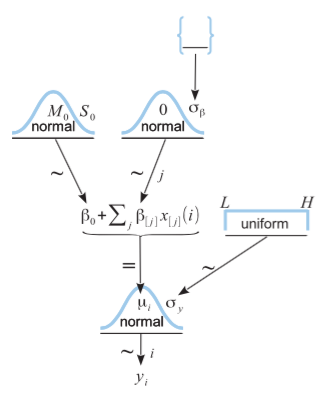

In [8]:
Image('images/fig19_2.png')

In [9]:
x = df.CompanionNumber.cat.codes.values
y = df.Longevity
yMean = y.mean()
ySD = y.std()

NxLvl = len(df.CompanionNumber.cat.categories)

agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as model1:
    
    aSigma = pm.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pm.Uniform('ySigma', ySD/100, ySD*10)
    y = pm.Normal('y', a0 + a[x], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0) 

In [10]:
with model1:
    trace1 = pm.sample(20000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 530.53: 100%|██████████| 200000/200000 [00:25<00:00, 7965.98it/s]
Finished [100%]: Average Loss = 530.53
100%|██████████| 20500/20500 [00:55<00:00, 371.49it/s]


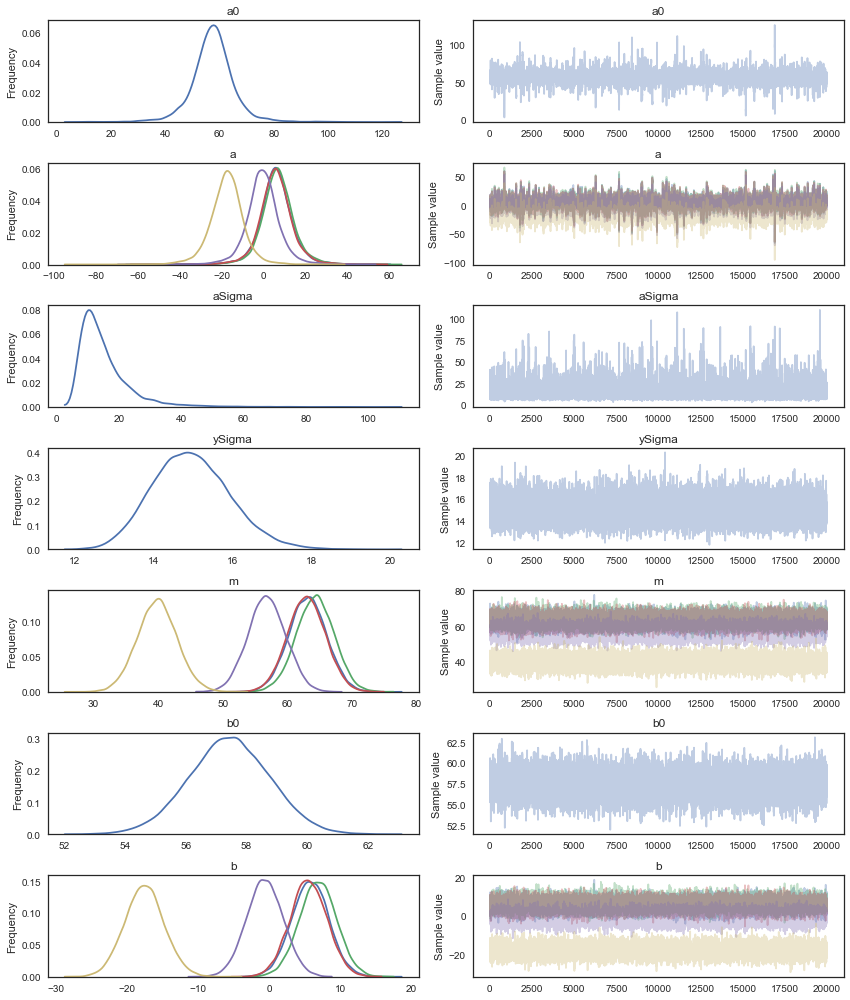

In [11]:
pm.traceplot(trace1);

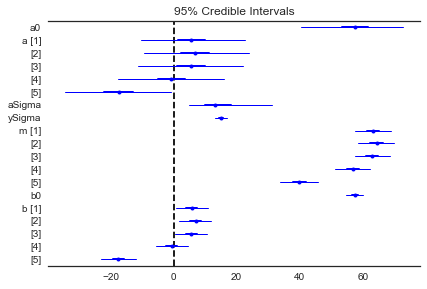

In [12]:
pm.forestplot(trace1);

In [13]:
pm.df_summary(trace1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a0,57.564398,8.120007,0.134447,40.532450,72.747754
a__0,5.631765,8.438314,0.136838,-10.357768,22.685863
a__1,6.762014,8.420154,0.136402,-9.462617,24.034074
a__2,5.432687,8.440457,0.133502,-11.237520,22.020210
a__3,-0.766795,8.397502,0.129503,-17.737396,15.839426
a__4,-17.706834,8.521657,0.132021,-34.459883,-0.866264
aSigma,15.303002,8.260058,0.105542,4.904821,31.148701
ySigma,14.956473,0.976925,0.007634,13.057989,16.848049
m__0,63.196163,2.924823,0.016886,57.488083,68.924927
m__1,64.326412,2.916633,0.019162,58.519189,69.952965


#### Figure 19.3 (top)

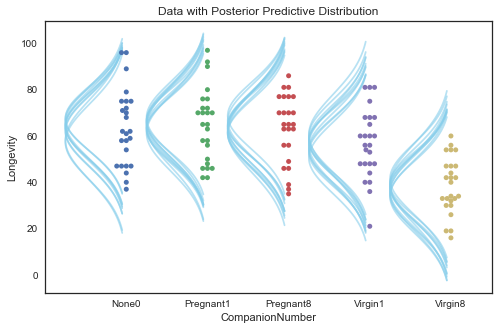

In [14]:
# Here we plot the metric predicted variable for each group. Then we superimpose the 
# posterior predictive distribution
burnin = 200

None0 = trace1['m'][burnin:,0]
Pregnant1 = trace1['m'][burnin:,1]
Pregnant8 = trace1['m'][burnin:,2]
Virgin1 = trace1['m'][burnin:,3]
Virgin8 = trace1['m'][burnin:,4]
scale = trace1['ySigma'][burnin:]

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.set_title('Data with Posterior Predictive Distribution')

sns.swarmplot('CompanionNumber', 'Longevity', data=df, ax=ax);
ax.set_xlim(xmin=-1)

for i, grp in enumerate([None0, Pregnant1, Pregnant8, Virgin1, Virgin8]):
    plot_mustache(grp, scale, i, ax)

#### Contrasts

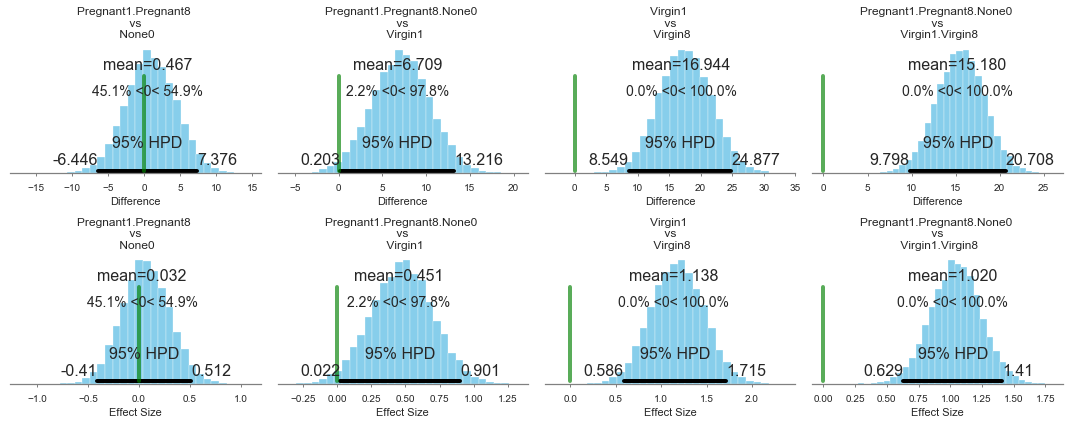

In [15]:
fig, axes = plt.subplots(2,4, figsize=(15,6))

contrasts = [np.mean([Pregnant1, Pregnant8], axis=0)-None0,
             np.mean([Pregnant1, Pregnant8, None0], axis=0)-Virgin1,
             Virgin1-Virgin8,
             np.mean([Pregnant1, Pregnant8, None0], axis=0)-np.mean([Virgin1, Virgin8], axis=0)]

contrast_titles = ['Pregnant1.Pregnant8 \n vs \n None0',
                   'Pregnant1.Pregnant8.None0 \n vs \n Virgin1',
                   'Virgin1 \n vs \n Virgin8',
                   'Pregnant1.Pregnant8.None0 \n vs \n Virgin1.Virgin8']

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles, fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr/scale, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()

### 19.4 - Adding a Metric Predictor

#### Model (Kruschke, 2015)

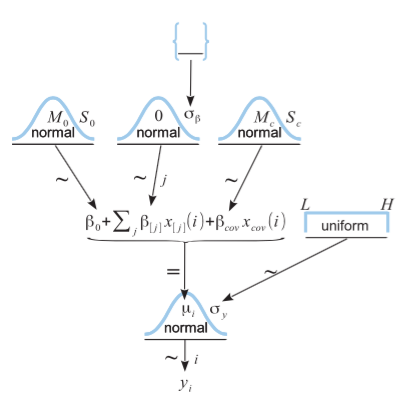

In [16]:
Image('images/fig19_4.png')

In [17]:
y = df.Longevity
yMean = y.mean()
ySD = y.std()
xNom = df.CompanionNumber.cat.categories
xMet = df.Thorax
xMetMean = df.Thorax.mean()
xMetSD = df.Thorax.std()
NxNomLvl = len(df.CompanionNumber.cat.categories)

X = pd.concat([df.Thorax, pd.get_dummies(df.CompanionNumber, drop_first=True)], axis=1)
lmInfo = LinearRegression().fit(X, y)
residSD = np.sqrt(mean_squared_error(y, lmInfo.predict(X)))

agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as model2:
    
    aSigma = pm.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxNomLvl)
    aMet = pm.Normal('aMet', 0, tau=1/(2*ySD/xMetSD)**2)
       
    ySigma = pm.Uniform('ySigma', residSD/100, ySD*10)
    
    mu = a0 + a[x] + aMet*(xMet - xMetMean)
    y = pm.Normal('y', mu, tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    b0 = pm.Deterministic('b0', a0 + tt.mean(a) + aMet*(-xMetMean))
    b = pm.Deterministic('b', a - tt.mean(a)) 

In [18]:
with model2:
    trace2 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 492.74: 100%|██████████| 200000/200000 [00:29<00:00, 6692.53it/s]
Finished [100%]: Average Loss = 492.74
100%|█████████▉| 10482/10500 [00:33<00:00, 323.92it/s]/Users/jordi/anaconda/envs/probalistic/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:247: UserWarning: Chain 0 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)
100%|██████████| 10500/10500 [00:33<00:00, 315.53it/s]


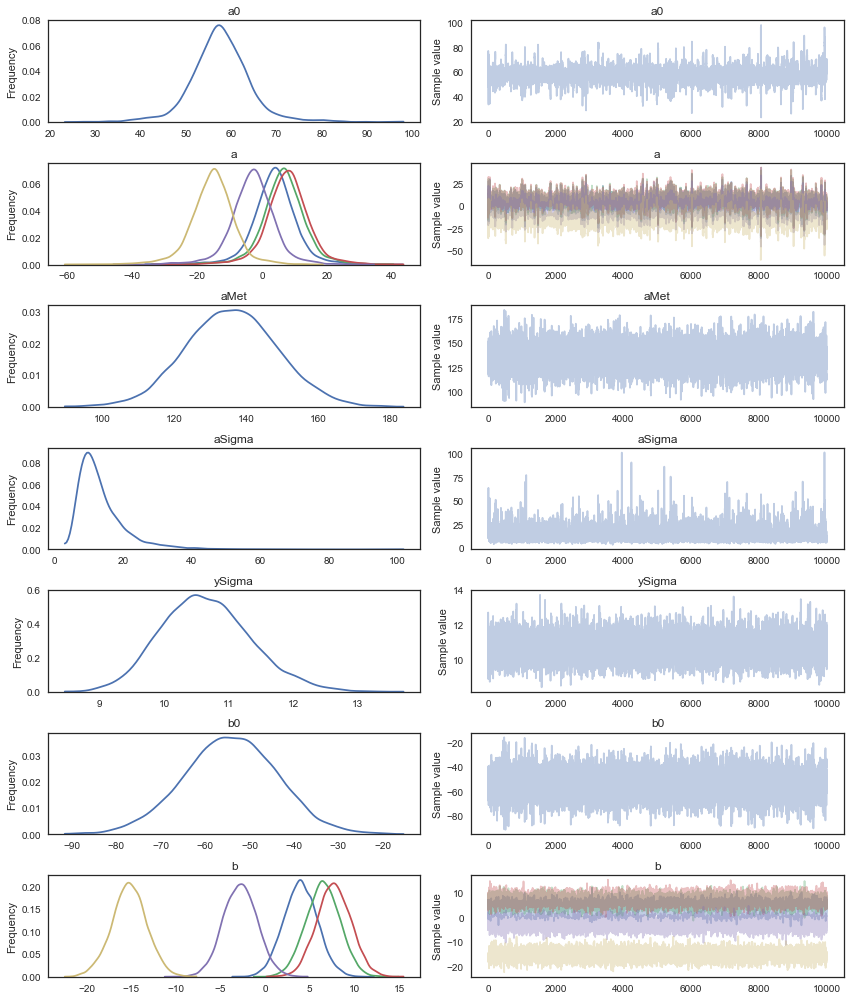

In [19]:
pm.traceplot(trace2);

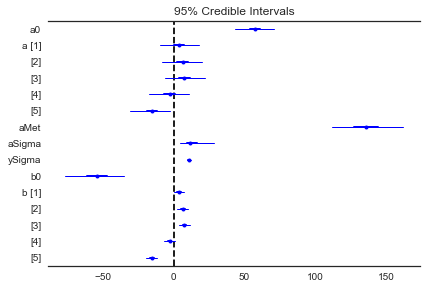

In [20]:
pm.forestplot(trace2);

In [21]:
pm.df_summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a0,57.478162,6.636334,0.163735,43.231859,70.803441
a__0,3.864103,6.813591,0.160039,-9.860229,18.027824
a__1,6.414876,6.831015,0.159998,-7.953438,19.927009
a__2,7.638800,6.868084,0.163126,-6.206441,21.909440
a__3,-2.891200,6.855832,0.165103,-17.343127,10.787983
a__4,-15.317414,6.885270,0.166372,-30.593338,-2.178786
aMet,136.011681,12.793632,0.113970,111.948071,162.080473
aSigma,13.837996,7.339591,0.127195,4.683906,28.430375
ySigma,10.643486,0.696783,0.005584,9.323610,12.047541
b0,-54.240155,10.550049,0.091975,-76.555186,-35.042133


#### Figure 19.5

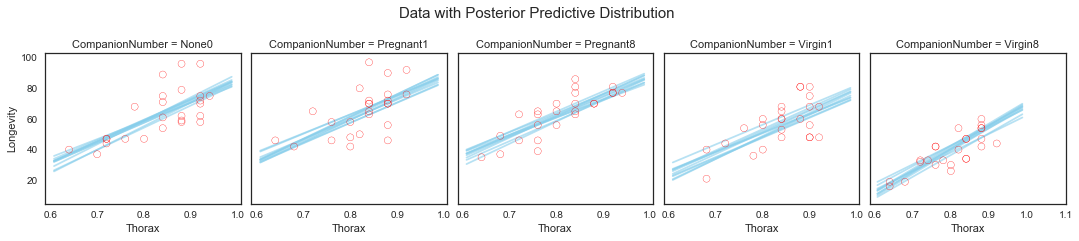

In [22]:
# Here we plot, for every group, the predicted variable and the metric predictor.
# Superimposed are are the posterior predictive distributions.
fg = sns.FacetGrid(df, col='CompanionNumber', despine=False)
fg.map(plt.scatter, 'Thorax', 'Longevity', facecolor='none', edgecolor='r')

plt.suptitle('Data with Posterior Predictive Distribution', y=1.10, fontsize=15)
for i, ax in enumerate(fg.axes.flatten()):
    plot_cred_lines(trace2['b0'][burnin:],
                    trace2['b'][burnin:,i],
                    trace2['aMet'][burnin:],
                    xMet, ax)
    ax.set_xticks(np.arange(.6, 1.1, .1));

#### Contrasts

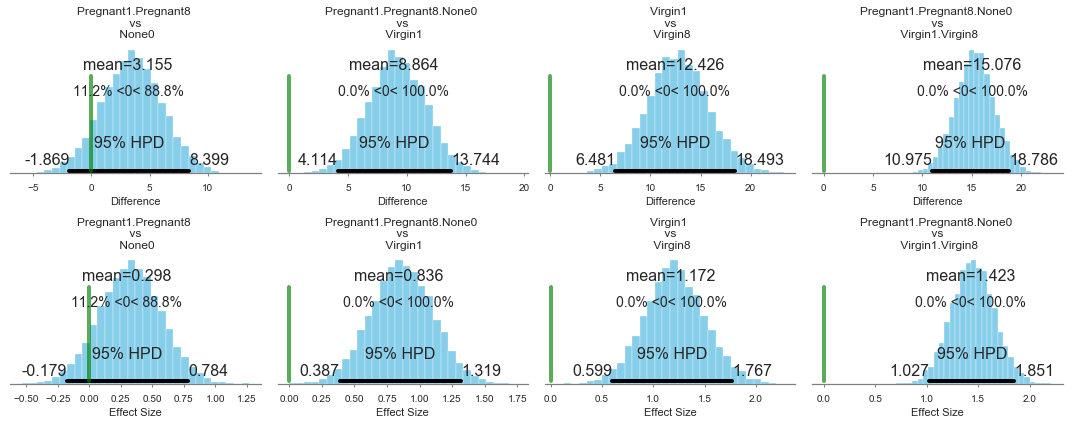

In [23]:
burnin = 200

None0 = trace2['b'][burnin:,0]
Pregnant1 = trace2['b'][burnin:,1]
Pregnant8 = trace2['b'][burnin:,2]
Virgin1 = trace2['b'][burnin:,3]
Virgin8 = trace2['b'][burnin:,4]
scale = trace2['ySigma'][burnin:]

fig, axes = plt.subplots(2,4, figsize=(15,6))

contrasts = [np.mean([Pregnant1, Pregnant8], axis=0)-None0,
             np.mean([Pregnant1, Pregnant8, None0], axis=0)-Virgin1,
             Virgin1-Virgin8,
             np.mean([Pregnant1, Pregnant8, None0], axis=0)-np.mean([Virgin1, Virgin8], axis=0)]

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles, fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr/scale, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()

### 19.5 - Heterogeneous Variances and Robustness against Outliers

In [24]:
df2 = pd.read_csv('data/NonhomogVarData.csv', dtype={'Group':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
Group    96 non-null category
Y        96 non-null float64
dtypes: category(1), float64(1)
memory usage: 976.0 bytes


In [25]:
df2.groupby('Group').head(3)

,Group,Y
0,A,97.770214
1,A,99.919872
2,A,92.372917
24,B,98.246778
25,B,98.736006
26,B,98.722708
48,C,102.432580
49,C,102.198665
50,C,103.052658
72,D,97.561346


#### Model (Kruschke, 2015)

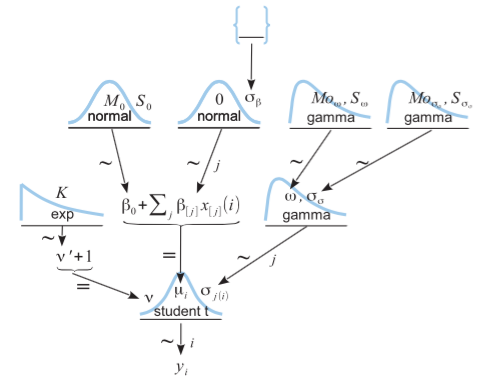

In [26]:
Image('images/fig19_6.png')

In [27]:
y = df2.Y
x = df2.Group.cat.codes.values
xlevels = df2.Group.cat.categories
NxLvl = len(xlevels) 
yMean = y.mean()
ySD = y.std()

aGammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)
medianCellSD = df2.groupby('Group').std().dropna().median()

with pm.Model() as model3:
    
    aSigma = pm.Gamma('aSigma', aGammaShRa[0], aGammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*10)**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
    
    ySigmaSD = pm.Gamma('ySigmaSD', aGammaShRa[0], aGammaShRa[1])
    ySigmaMode = pm.Gamma('ySigmaMode', aGammaShRa[0], aGammaShRa[1])
    ySigmaRa = (ySigmaMode + np.sqrt(ySigmaMode**2 + 4*ySigmaSD**2))/2*ySigmaSD**2
    ySigmaSh = ySigmaMode*ySigmaRa
        
    sigma = pm.Gamma('sigma', ySigmaSh, ySigmaRa, shape=NxLvl)
    ySigma = pm.Deterministic('ySigma', tt.maximum(sigma, medianCellSD/1000))
    nu = pm.Exponential('nu', 1/30.)
    like = pm.StudentT('y', nu=nu, mu=a0 + a[x], sd=ySigma[x], observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0) 

In [28]:
with model3:
    trace3 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 267.12: 100%|██████████| 200000/200000 [00:51<00:00, 3878.38it/s]  
Finished [100%]: Average Loss = 267.12
100%|██████████| 10500/10500 [01:12<00:00, 144.23it/s]


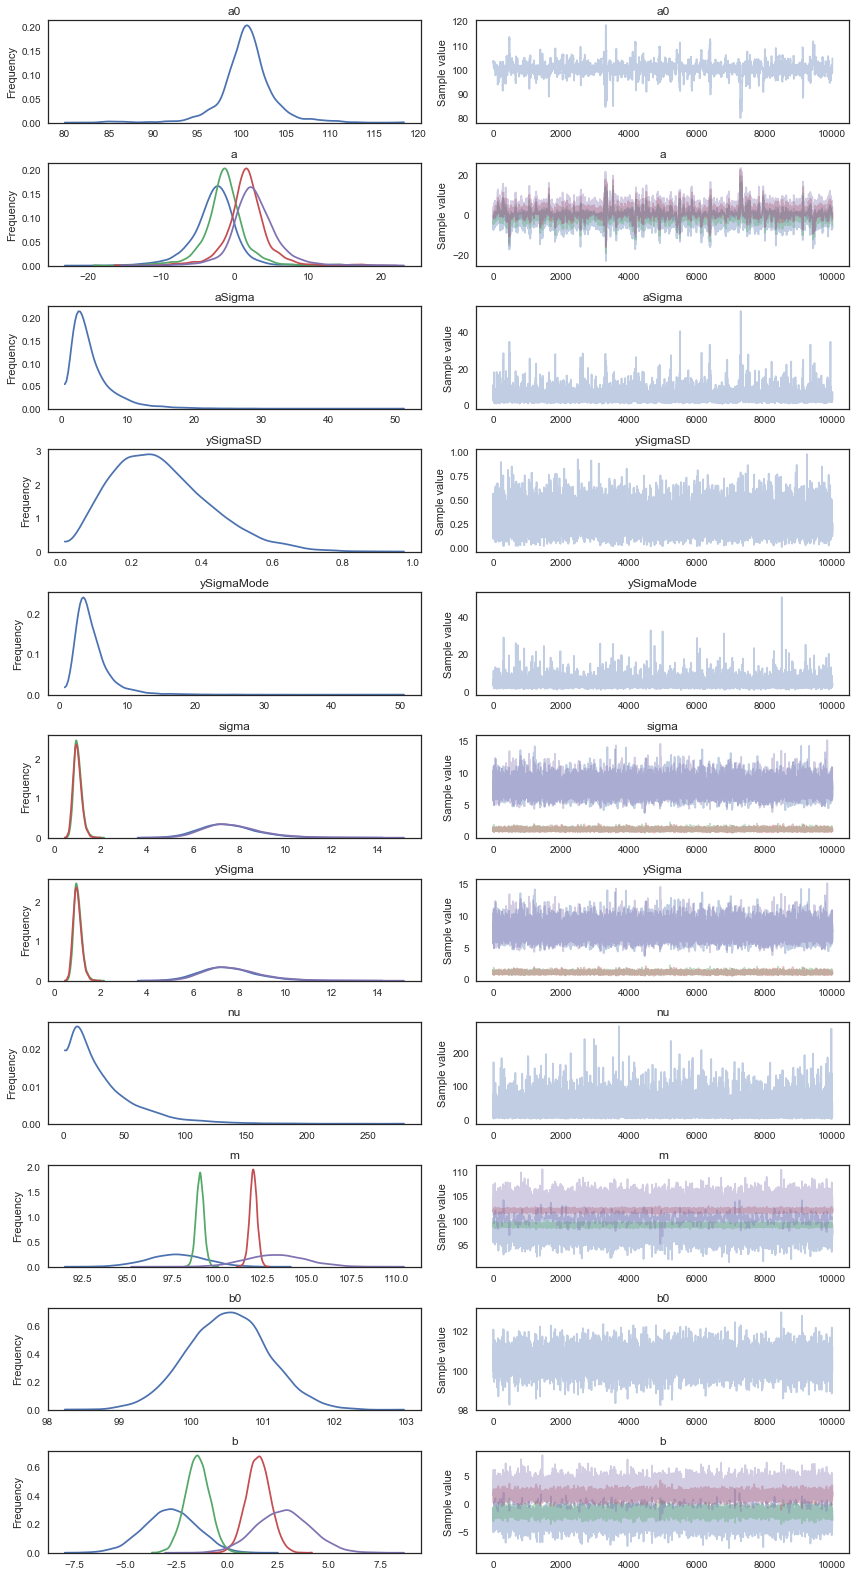

In [29]:
pm.traceplot(trace3);

In [30]:
pm.df_summary(trace3[5000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a0,100.353593,3.149316,0.203500,93.207376,106.186554
a__0,-2.648309,3.314956,0.195084,-9.830431,3.505184
a__1,-1.318504,3.150454,0.203434,-7.817875,5.120548
a__2,1.660193,3.154751,0.203362,-4.157693,8.745884
a__3,2.863870,3.385885,0.196538,-4.034828,9.297648
aSigma,4.752125,3.549537,0.165540,0.866377,11.324071
ySigmaSD,0.282440,0.137154,0.002516,0.048983,0.545753
ySigmaMode,4.844647,2.722999,0.064672,1.095694,9.689102
sigma__0,7.536757,1.259419,0.015214,5.160631,10.049095
sigma__1,1.009153,0.178238,0.002137,0.661550,1.347784


#### Model that assumes equal variances

In [31]:
y = df2.Y
x = df2.Group.cat.codes.values
xlevels = df2.Group.cat.categories
NxLvl = len(xlevels) 
yMean = y.mean()
ySD = y.std()

aGammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as model3b:
    
    aSigma = pm.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pm.Uniform('ySigma', ySD/100, ySD*10)
    y = pm.Normal('y', a0 + a[x], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0) 
        
    trace3b = pm.sample(20000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 317.74: 100%|██████████| 200000/200000 [00:26<00:00, 7498.71it/s]
Finished [100%]: Average Loss = 317.74
100%|█████████▉| 20475/20500 [00:49<00:00, 402.88it/s]/Users/jordi/anaconda/envs/probalistic/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:247: UserWarning: Chain 0 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)
100%|██████████| 20500/20500 [00:49<00:00, 412.46it/s]


#### Figure 19.7

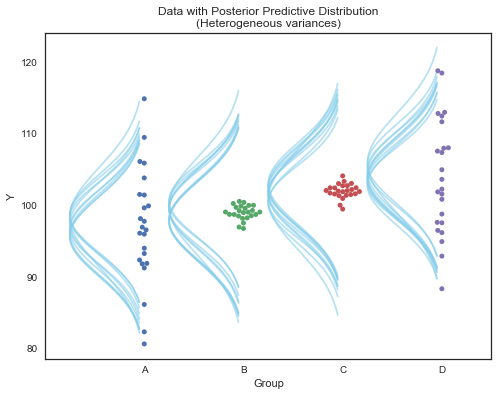

In [32]:
burnin = 5000

group_a = trace3b['m'][burnin:,0]
group_b = trace3b['m'][burnin:,1]
group_c = trace3b['m'][burnin:,2]
group_d = trace3b['m'][burnin:,3]
scale = trace3b['ySigma'][burnin:]
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_title('Data with Posterior Predictive Distribution\n(Heterogeneous variances)')

sns.swarmplot('Group', 'Y', data=df2, size=5, ax=ax)
ax.set_xlim(xmin=-1);

for i, grp, in enumerate([group_a, group_b, group_c, group_d]):
    plot_mustache(grp, scale, i, ax)

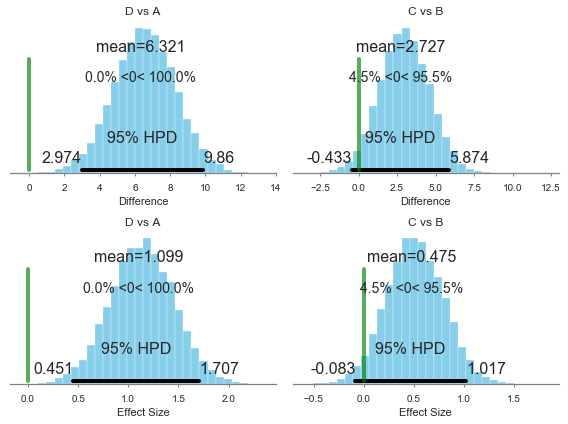

In [33]:
fig, axes = plt.subplots(2,2, figsize=(8,6))

contrasts = [group_d-group_a,
             group_c-group_b]

contrast_titles = ['D vs A',
                   'C vs B']

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles, fig.axes[:2], fig.axes[2:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr/scale, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()

#### Figure 19.8

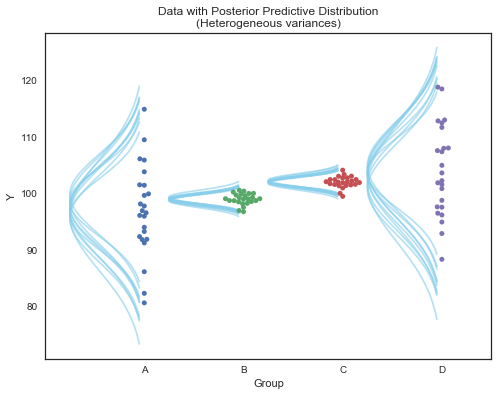

In [34]:
burnin = 5000

group_a = trace3['m'][burnin:,0]
group_b = trace3['m'][burnin:,1]
group_c = trace3['m'][burnin:,2]
group_d = trace3['m'][burnin:,3]
scale_a = trace3['ySigma'][burnin:,0]
scale_b = trace3['ySigma'][burnin:,1]
scale_c = trace3['ySigma'][burnin:,2]
scale_d = trace3['ySigma'][burnin:,3]

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_title('Data with Posterior Predictive Distribution\n(Heterogeneous variances)')

sns.swarmplot('Group', 'Y', data=df2, size=5, ax=ax)
ax.set_xlim(xmin=-1);

for i, (grp, scale) in enumerate(zip([group_a, group_b, group_c, group_d],
                                     [scale_a, scale_b, scale_c, scale_d])):
    plot_mustache(grp, scale, i, ax)

#### Contrasts

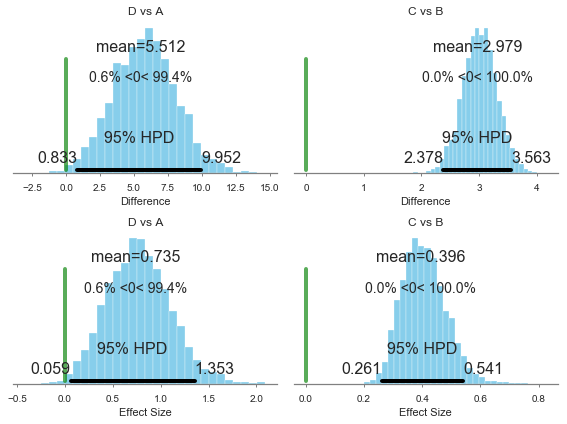

In [35]:
fig, axes = plt.subplots(2,2, figsize=(8,6))

contrasts = [group_d-group_a,
             group_c-group_b]

contrast_titles = ['D vs A',
                   'C vs B']

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles, fig.axes[:2], fig.axes[2:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr/scale, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()